# Membership Inference Attack to synthetic trajectories

Import libraries:
- pytorch
- pandas
- numpy
- matplotlib

In [288]:
# Temporary fix to kernel not responding
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Import necessary libraries
import torch
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [289]:
#epsilon for differential privacy
epsilon=0

#desired_variance = 1 - maximum information loss 
desired_variance = 0.99

#KNN number of neighbors
k=50

#KNN distance metric ['euc', 'sqd', 'max', 'cab']
distance_metric = 'euc'

## Define the data paths

In [290]:
file_path_t = f'../epsilon{epsilon}/test.data'
file_path_v = f'../epsilon{epsilon}/val.data'
file_path_s = f'../epsilon{epsilon}/gene.data'
file_path_tr = f'../epsilon{epsilon}/real.data'

## Define custom datasets
One is for the positive and negative examples and another for the synthetic data

In [291]:
class TrajectoryDataset(Dataset):
    def __init__(self, data, labels):
        '''
            Dataset for the real train and test data.
            ## Inputs:
            - data: tensor with the trajectories of shape (N, L). N being the number of trajectories and L the length of each trajectory
            - labels: tensor of shape (N). N being the number of trajectories. It can be either one or zero, depending on if its is positive or negative.
        '''
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class SyntheticDataset(Dataset):
    def __init__(self, data):
        '''
            Dataset for the synthetic data obtained from a generator model.
            ## Inputs:
            - data: tensor with the synthetic trajectories of shape (N, L). N being the number of trajectories and L the length of each trajectory
        '''
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

## Load Data
Load the train, validation and test datasets as well as the synthetic trajectories.

In [292]:
data_test = pd.read_csv(file_path_t, sep=" ", header=None)
data_test = torch.unique(torch.Tensor(data_test.values), dim=0)

data_validation = pd.read_csv(file_path_v, sep=" ", header=None)
data_validation = torch.unique(torch.Tensor(data_validation.values), dim=0)

data_negative  = torch.cat([data_test, data_validation])

data_synthetic = pd.read_csv(file_path_s, sep=" ", header=None)
data_synthetic = torch.unique(torch.Tensor(data_synthetic.values), dim=0)

data_train = pd.read_csv(file_path_tr, sep=" ", header=None)
data_positive = torch.unique(torch.Tensor(data_train.values), dim=0)

## PCA
We want to perform PCA to the trajectories in order to reduce the dimensionality of the trajectories. First define the functions to perform the singular value decomposition and to display the shape of the tensors.

In [293]:
def perform_svd(data):
    # Compute the SVD where S is the eigenvalues and V is the eigenvectors
    U, S, V = torch.linalg.svd(data)

    return U, S, V

def display_shape(S, V):
    print("Shape of eigenvalues (S):", S.shape)
    print("Shape of eigenvectors (V):", V.shape)

In [294]:
# Perform SVD on the converted DataFrame
U_s, S_s, V_s= perform_svd(data_synthetic)

display_shape(S_s, V_s)

Shape of eigenvalues (S): torch.Size([48])
Shape of eigenvectors (V): torch.Size([48, 48])


### Variance of the components
A study on the cumulative variance of the components in the singular value decomposition

In [295]:
def calculate_cumulative_variance(S):
    # Calculate the variance explained by each principal component
    variance_explained = (S ** 2) / torch.sum(S ** 2)

    # Calculate the cumulative variance explained
    cumulative_variance_explained = torch.cumsum(variance_explained, dim=0)

    return cumulative_variance_explained

In [296]:
cumulative_variance_synthetic = calculate_cumulative_variance(S_s)

In [297]:
def scree_graph(cumulative_variance_synthetic):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance_synthetic) + 1), cumulative_variance_synthetic, linestyle='-', marker='x', color='blue', label='Synthetic Data')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance')
    plt.legend()
    plt.title('Scree Graph')
    plt.show()

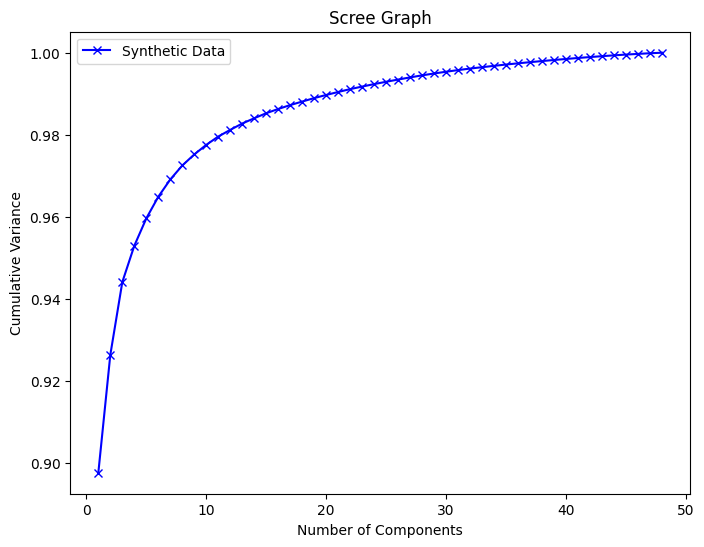

In [298]:
scree_graph(cumulative_variance_synthetic)

In [299]:
def get_num_components(cumulative_variance_explained, desired_variance):
    num_components = torch.sum(cumulative_variance_explained < desired_variance) + 1
    return num_components.item()

num_components_needed_syn = get_num_components(cumulative_variance_synthetic, desired_variance)
print("Number of principal components needed for a cumulative variance explained of", desired_variance, ":", num_components_needed_syn, " components")

Number of principal components needed for a cumulative variance explained of 0.99 : 21  components


In [300]:
import torch
# Project the real_data onto the plane formed by the principal components
new_coordinates_positive = torch.matmul(data_positive,V_s[:, :num_components_needed_syn])
labels_positive = torch.ones(len(data_positive.data))  # Label real data with 1
positive = TrajectoryDataset(new_coordinates_positive, labels_positive)

# Project the synthetic onto the plane formed by the principal components
new_coordinates_synthetic = torch.matmul(data_synthetic,V_s[:, :num_components_needed_syn])
synthetic = SyntheticDataset(new_coordinates_synthetic)

# Project the positive onto the plane formed by the principal components
new_coordinates_negative = torch.matmul(data_negative,V_s[:, :num_components_needed_syn])
labels_negative = torch.ones(len(data_negative.data))  # Label real data with 0
negative = TrajectoryDataset(new_coordinates_negative, labels_negative)

### Comparing the first and second principal components
A study to know the similituds between the first and second principal components

In [301]:
# Plotting the real and synthetic new coordinates
def new_coordinates_comparison(new_coordinates_positive, new_coordinates_synthetic, new_coordinates_negative, num_components_needed):
    if(num_components_needed < 2):
        return
    else:
        plt.figure(figsize=(8, 6))
        plt.scatter(new_coordinates_positive[:, 0], new_coordinates_positive[:, 1], label='Real', s=1)
        plt.scatter(new_coordinates_negative[:, 0], new_coordinates_negative[:, 1], label='Train', s=1)
        plt.scatter(new_coordinates_synthetic[:, 0], new_coordinates_synthetic[:, 1], label='Synthetic', s=1)
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.title('New Coordinates on First and Second Principal Components')
        plt.legend()
        plt.show()

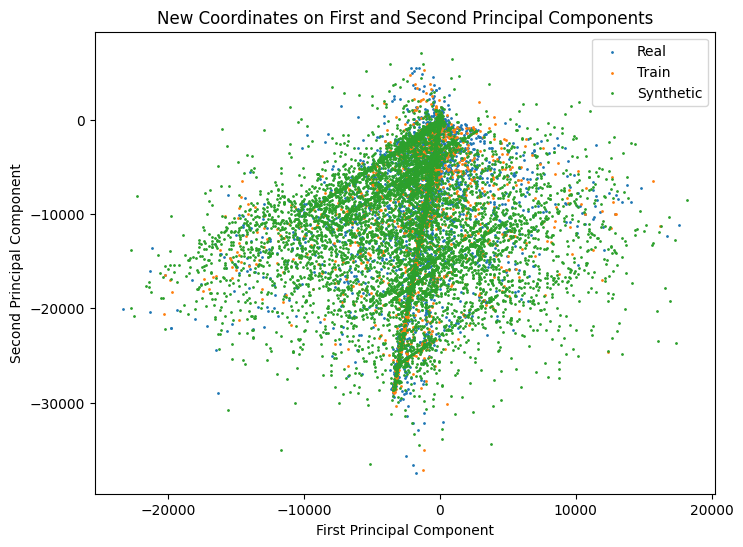

In [302]:
new_coordinates_comparison(positive.data, synthetic.data, negative.data, num_components_needed_syn)

# KNN
Perform the KNN to the datasets after performing the PCA

In [303]:
from typing import Optional

class KNN():
    def __init__(self, distance:str = 'max') -> None:
        self.constellation = None
        self.labels = None
        self.dim = None
        self.available_dist = ['euc', 'sqd', 'max', 'cab']
        self.ensure_distance(distance)
        self.distance = distance
    
    def fit(self, constellation:torch.Tensor, labels:Optional[torch.Tensor]=None)-> None:
        self.constellation = constellation
        self.labels = labels
        self.dim = len(self.constellation.shape)-1
    
    def set_distance(self, distance: str)-> None:
        self.ensure_distance(distance)
        self.distance = distance
    
    def ensure_distance(self, distance):
        if distance not in self.available_dist:
            raise NotAvailableFeature(f'Feature not available {distance}, currently only available distances: {self.available_dist}')
    
    def compute_distance(self, X:torch.Tensor)-> torch.Tensor:
        '''
        Computing distances from X to each point in the constellation depending on the self.distance value the metric will differ:
            - euc: Euclidean distance between points
            - sqd: Squared euclidean distance
            - max: Tchebychev distance (maximum metric)
            - cab: Taxicab distance or Manhattan distance
        '''
        if self.distance == self.available_dist[0]:
            dist = self.constellation.add( - X).pow(2).sum(dim=self.dim).pow(.5) 
        elif self.distance == self.available_dist[1]:
            dist = self.constellation.add( - X).pow(2).sum(dim=self.dim)
        elif self.distance == self.available_dist[2]:
            dist = torch.abs(self.constellation.add( - X)).max(dim=self.dim).values
        elif self.distance == self.available_dist[3]:
            dist = torch.abs(self.constellation.add( - X)).sum(dim=self.dim)
        return dist
    
    def kneighbours(self, X:torch.Tensor, k:int=4)-> tuple:
        '''
        Inputs:
        - X: A single trajectory that we want to check if it is similar to the original data.
        - k: the number of k nearest neighbours we want to see in the output
        
        Outputs:
        - dist: Distances to the first k-nearest neighbours
        - knn_indices: Indexes of the k-nearest neighbours
        '''
        if self.dim != None and self.dim>0:
            X = X.expand(self.constellation.shape) # Repeat the same two point traj N times until shape matches with the synthetic trajectories

            # Computing distance
            dist = self.compute_distance(X)
            # Getting the k nearest points
            knn_indices = dist.topk(k, largest=False, sorted=False)[1] # Getting the k smallest distances

            return dist[knn_indices], knn_indices
        else:
            raise ModelNotFit('The model has not been fit with the constellation or the constellation is empty. Before using model.kneighbours use model.fit with a propper constellation')
        
class ModelNotFit(Exception):
    def __init__(self, *args: object) -> None:
        super().__init__(*args)

class NotAvailableFeature(Exception):
    def __init__(self, *args: object) -> None:
        super().__init__(*args)

In [304]:
synthetic = SyntheticDataset(synthetic.data)
negative = TrajectoryDataset(negative.data, labels=torch.zeros(len(negative)))
positive = TrajectoryDataset(positive.data, labels=torch.ones(len(positive)))

print(f'Length of synthetic dataset: {synthetic.data.shape}')
print(f'Length of positive dataset: {positive.data.shape}')
print(f'Length of negative dataset: {negative.data.shape}')

Length of synthetic dataset: torch.Size([8765, 21])
Length of positive dataset: torch.Size([6540, 21])
Length of negative dataset: torch.Size([3380, 21])


We can define a new K, up until now choosing a bigger K means obtaining better AUC. 

#### Important 
- max(K) = N<sub>synthetic</sub>

In [305]:
# Create an instance of the KNN class
knn = KNN(distance_metric)

# Fit the KNN model with the synthetic data
knn.fit(synthetic.data)

classes = ['Train', 'No Train']

def predict(test:Dataset, k:int = 2):
    distances = torch.LongTensor([])
    idx = torch.IntTensor([])
    for i, (data, label) in enumerate(test):
        dist, knn_indices = knn.kneighbours(data, k=k)
        dist=dist.unsqueeze(0)
        knn_indices = knn_indices.unsqueeze(0)
        distances = torch.cat([distances, dist], dim=0)
        idx = torch.cat([idx, knn_indices], dim=0)
        
    prob  = torch.mean(1- (distances-distances.min()) / (distances.max()-distances.min()), dim=1)
    return prob, idx

pos_prob, pos_idx = predict(positive, k)
neg_prob, neg_idx = predict(negative, k)

In [306]:
import sklearn.metrics as metrics

preds = torch.cat([pos_prob, neg_prob])
y_test = torch.cat([positive.labels, negative.labels]).type(torch.uint8)

all_data = torch.cat([data_positive, data_negative], dim=0)
results = torch.cat([all_data, torch.cat([preds.unsqueeze(-1), y_test.unsqueeze(-1)], dim=-1)], dim=-1)

preds= preds.tolist()
y_test = y_test.tolist()

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

Text(0.5, 0, 'False Positive Rate')

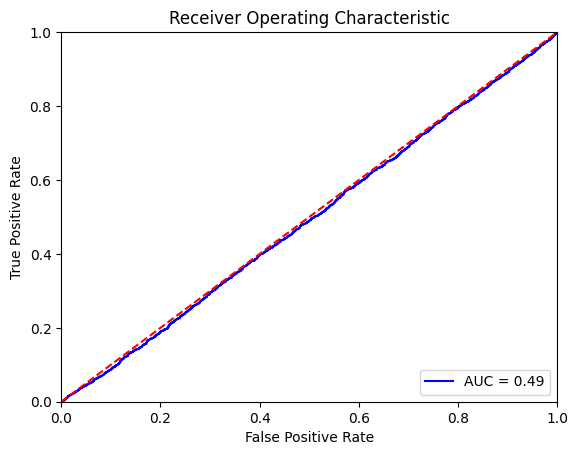

In [307]:
import matplotlib.pyplot as plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')